In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx

import numpy as np
import time

from history import History
from optimisers import train_step, resample_rad, AggressiveLM, PlateauLM

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson2D
problem = Poisson2D()

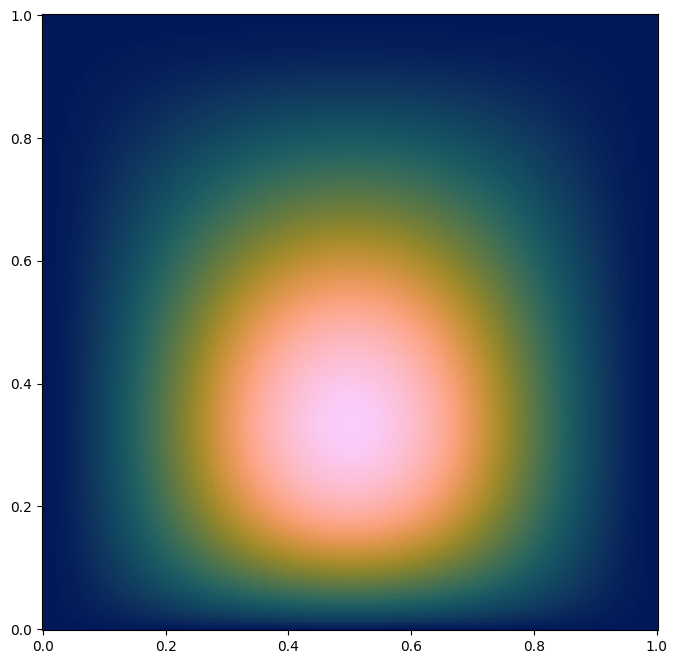

In [3]:
X, T, u_solution = problem.exact_solution(nx=256, ny=256)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.pcolormesh(X, T, u_solution, cmap=cmap)

In [4]:
key = jax.random.PRNGKey(42)

layer_sizes = [2, 20, 20, 20, 20, 1]

model_key, sample_key = jax.random.split(key, 2)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
model = eqx.combine(params, static) 

# --- Collocation points ---
resample_every_n_epochs = 50
rad_k = 1.0
rad_c = 5.0
n_collocation_points = 2**14
n_candidate_points = 20 * n_collocation_points
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)
collocation_points = resample_rad(
    model,
    candidate_points,
    n_collocation_points,
    problem,
    rad_k,
    rad_c,
    sample_key
)

optimiser = AggressiveLM(
    init_lambda=1e0,
    increase_factor=1.01,
    max_increase=2.0,
    optimism_factor=0.9,
    decrease_factor=0.9,
)
# optimiser = PlateauLM(
#     init_lambda=1e3,
#     increase_factor=1.01,
#     max_increase=2.0,
#     plateau_factor=1.01,
# )
opt_state = optimiser.init(params)

history = History()


<function matplotlib.pyplot.show(close=None, block=None)>

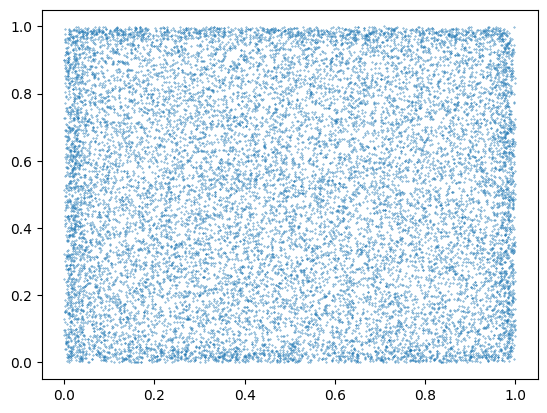

In [5]:
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

In [6]:
epoch = 0
total_train_step_time = 0

In [7]:
for _ in range(250):
    
    # Resample
    if epoch % resample_every_n_epochs == 0 and epoch > 0:
        model = eqx.combine(params, static) 
        
        sample_key, subkey = jax.random.split(sample_key, 2)
        collocation_points = resample_rad(
            model, 
            candidate_points, 
            n_collocation_points, 
            problem,
            rad_k,
            rad_c,
            subkey
        )

    # Train
    start_train_step_time = time.monotonic()
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    end_train_step_time = time.monotonic()
    total_train_step_time += (end_train_step_time - start_train_step_time)
        
    # Print and record
    model = eqx.combine(params, static)
    u_pred = model.predict(X, T)
    error = np.abs(u_solution - u_pred)
    rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

    metrics["rell2error"] = rel_l2_error
    metrics["time"] = total_train_step_time
        
    history.record(metrics)

    if epoch % (resample_every_n_epochs // 2) == 0:
        print(f"Epoch {epoch}, Loss: {loss_val.item():.3e}")
        print(f"{rel_l2_error:.3e}", f"{total_train_step_time:.3f}")

    epoch += 1

model = eqx.combine(params, static)
print("Training complete.")

Epoch 0, Loss: 2.822e+04
5.732e+01 14.603
Epoch 25, Loss: 8.297e-02
7.040e-02 33.148
Epoch 50, Loss: 5.115e-02
6.657e-02 51.047
Epoch 75, Loss: 1.396e-02
3.161e-02 67.474
Epoch 100, Loss: 4.070e-04
6.395e-03 84.150
Epoch 125, Loss: 2.164e-04
3.321e-03 101.662
Epoch 150, Loss: 7.136e-05
5.161e-03 118.405
Epoch 175, Loss: 5.698e-07
1.220e-04 134.256
Epoch 200, Loss: 1.321e-08
4.513e-05 151.292
Epoch 225, Loss: 8.643e-10
1.416e-05 168.427


KeyboardInterrupt: 

In [8]:
from optimisers import compute_full_J_and_R
from jax.flatten_util import ravel_pytree
from functools import partial
import pandas as pd

In [9]:
params_flat, unflatten = ravel_pytree(params)

J, residuals = compute_full_J_and_R(
    params_flat, static, unflatten, problem.physics_residual, collocation_points
)

In [10]:
current_loss = jnp.mean(residuals**2)

U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
g = U.T @ residuals

In [11]:
min_s = jnp.min(S**2)
max_s = jnp.max(S**2)
lambdas = jnp.logspace(jnp.log10(min_s / 10), jnp.log10(max_s * 10), 50)

In [12]:
losses = []
search_direction_norms = []

for trial_lambda in lambdas:
    delta_flat = -Vt @ jnp.diag(S / (S**2 + trial_lambda)) @ g

    # Calculate trial parameters and loss
    trial_params = unflatten(params_flat + delta_flat)
    rebuilt_trial_model = eqx.combine(trial_params, static)
    trial_residuals = jax.vmap(partial(problem.physics_residual, rebuilt_trial_model))(collocation_points)
    trial_loss = jnp.mean(trial_residuals**2)
    losses.append(trial_loss)

    search_direction_norm = jnp.linalg.norm(delta_flat)
    search_direction_norms.append(search_direction_norm)

In [13]:
results_df = pd.DataFrame({
    'lambda': lambdas,
    'loss': losses,
    'search_direction_norm': search_direction_norms,
})

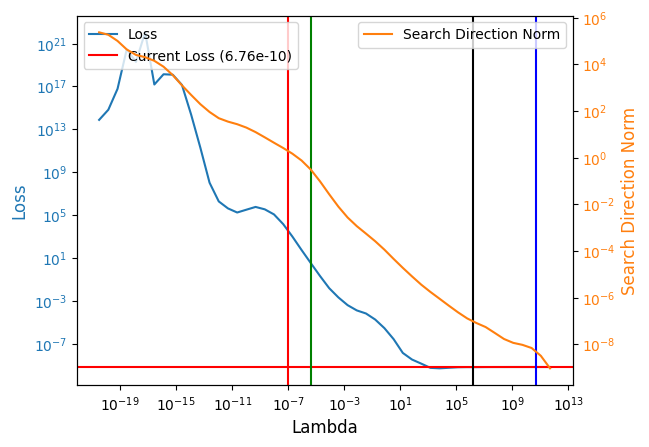

In [16]:
fig, ax = plt.subplots()
ax.set_ylabel('Loss', color='tab:blue', fontsize=12)
ax.plot(results_df['lambda'], results_df['loss'], color='tab:blue', label='Loss')
ax.axhline(current_loss, color='red', linestyle='-', label=f'Current Loss ({current_loss:.2e})')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Lambda', fontsize=12)

p25, p40, p50, p60, p75 = np.percentile(S**2, [25, 40, 50, 60, 75])

p99 = np.percentile(S**2, [99])


ax.axvline(p50, c="r")
ax.axvline(p75, c="g")
ax.axvline(p99, c="k")
ax.axvline(np.max(S**2), c="b")

ax.legend(loc='upper left')

# ax.axvline(metrics["lambda"])
# ax.axvline(opt_state["lambda"])

ax2 = ax.twinx()
ax2.set_ylabel('Search Direction Norm', color='tab:orange', fontsize=12)
ax2.plot(results_df['lambda'], results_df['search_direction_norm'], color='tab:orange', label='Search Direction Norm')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_yscale('log')
ax2.legend(loc='upper right')


In [16]:
loss, updates, new_opt_state, metrics = optimiser.update(
    params, static, opt_state, problem.physics_residual, collocation_points
)

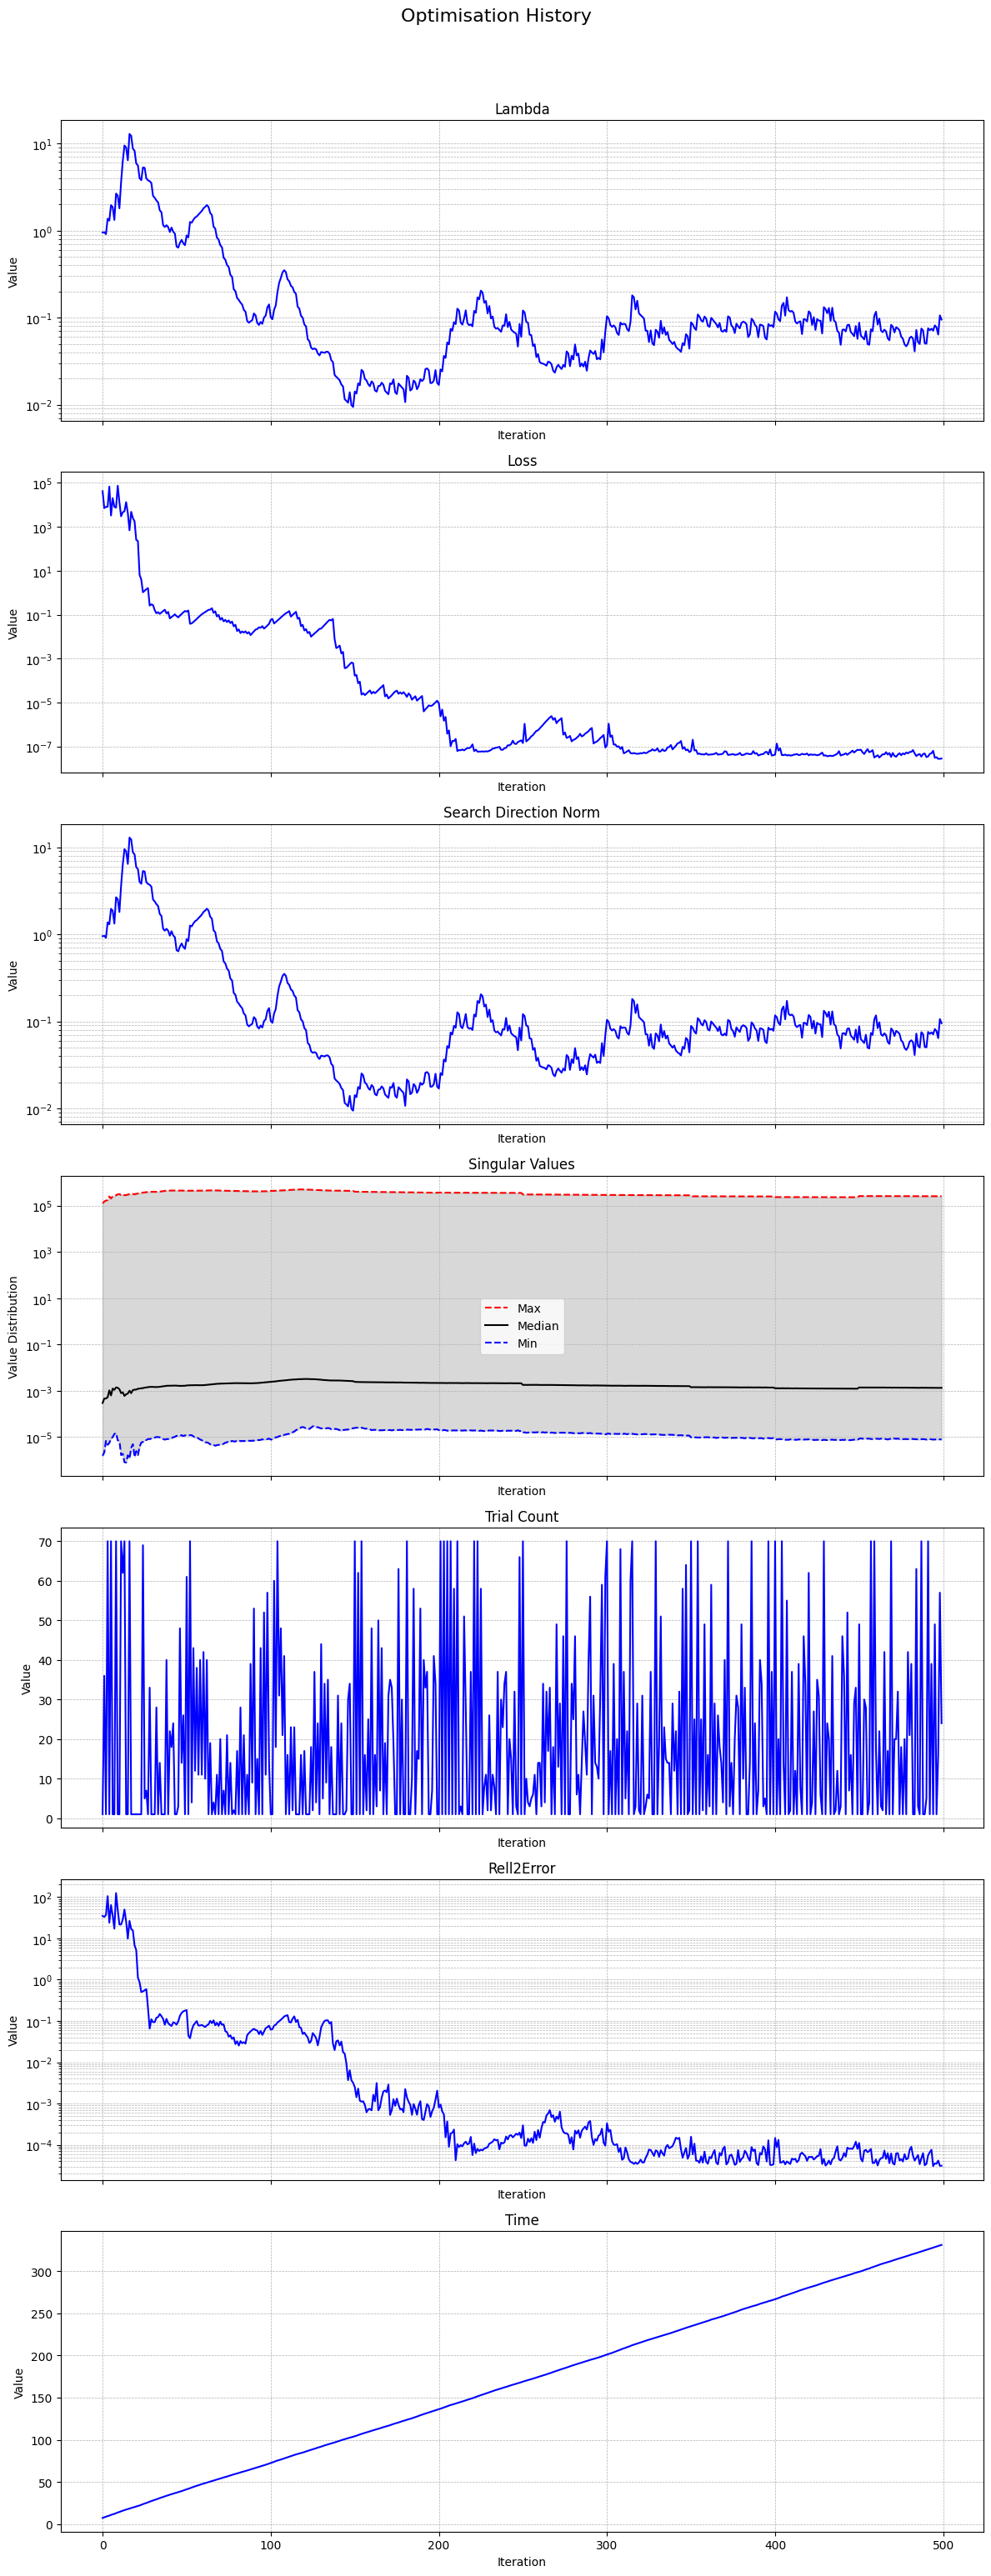

In [ ]:
history.plot()

Relative L2 Error: 2.550e-05


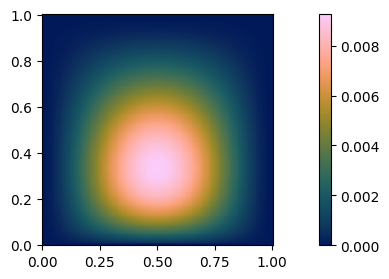

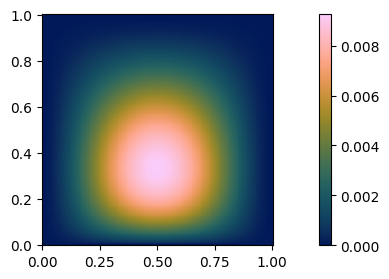

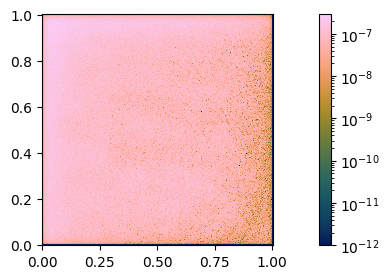

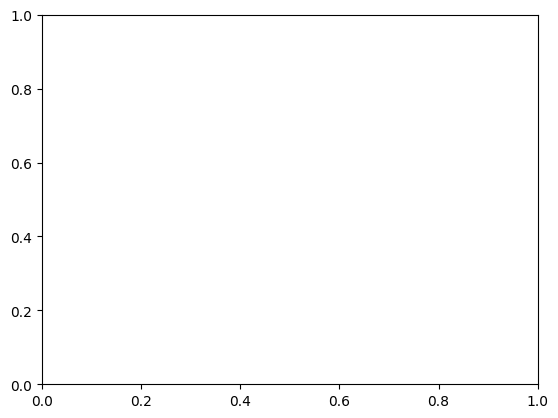

In [ ]:
model = eqx.combine(params, static)

u_pred = model.predict(X, T)

error = np.abs(u_solution - u_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_sol = ax.pcolormesh(X, T, u_solution, cmap=cmap)
fig.colorbar(ax_sol, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap)
fig.colorbar(ax_nn, ax=ax, pad=0.05)
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots()
plt.show()

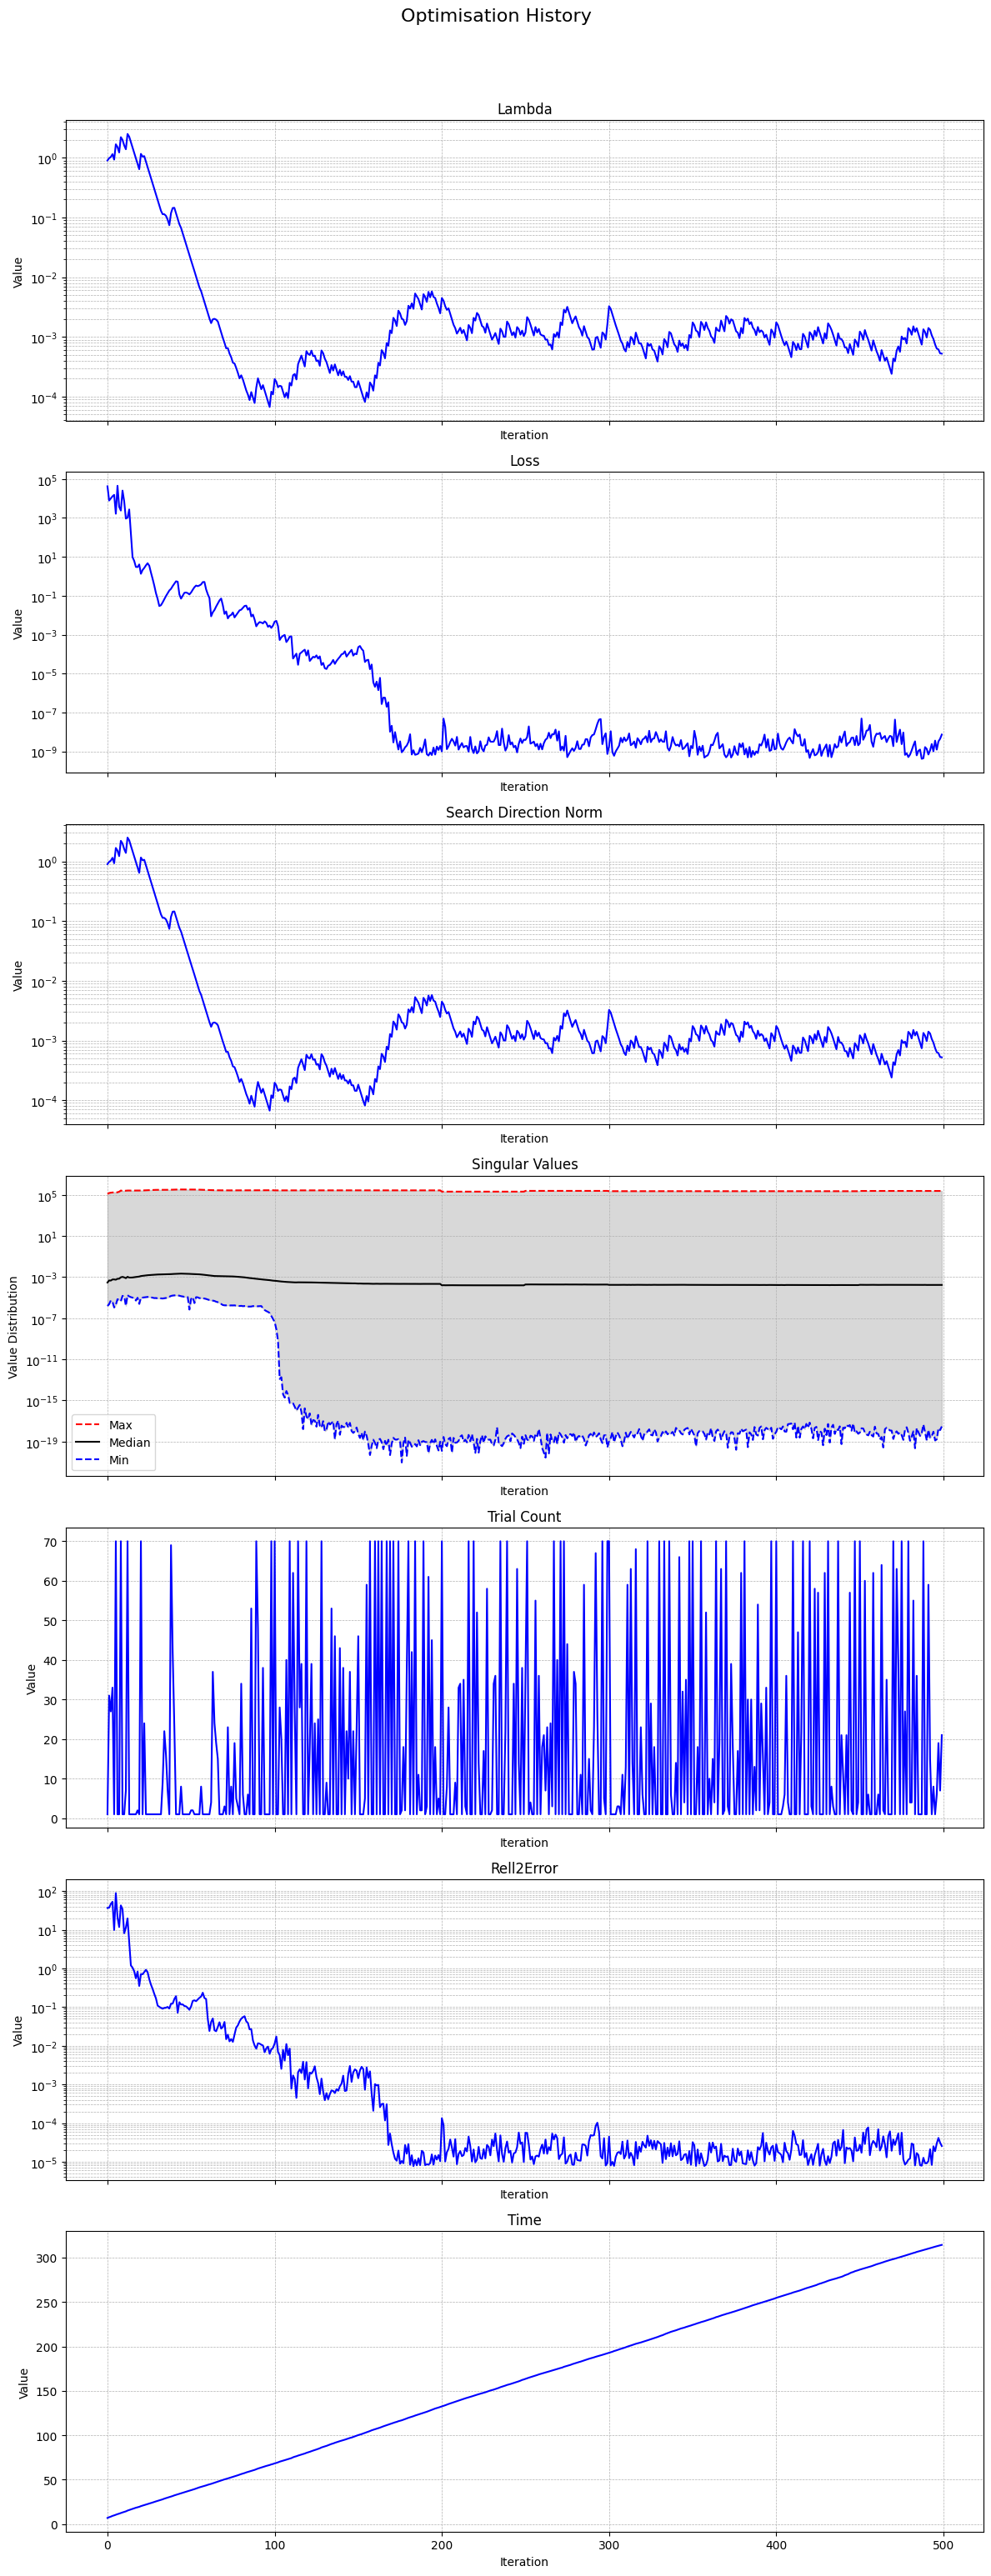

In [ ]:
history.plot()

In [ ]:
import scienceplots

plt.style.use(['science', 'no-latex'])

In [ ]:
burgerslm_l2err = history.history["rell2error"][:400]
burgerslm_loss = history.history["loss"][:400]
burgerslm_lambda = history.history["lambda"][:400]
burgerslm_searchdirnorm = history.history["search_direction_norm"][:400]
burgerslm_svs = history.history["singular_values"][:400]
burgerslm_time = history.history["time"][:400]

np.save('burgerslm_time.npy', burgerslm_time)
np.save('burgerslm_l2err.npy', burgerslm_l2err)
np.save('burgerslm_loss.npy', burgerslm_loss)
np.save('burgerslm_lambda.npy', burgerslm_lambda)
np.save('burgerslm_searchdirnorm.npy', burgerslm_searchdirnorm)
np.save('burgerslm_svs.npy', burgerslm_svs)
np.save('burgerslm_u_pred.npy', u_pred)
np.save('burgerslm_u_solution.npy', u_solution)
np.save('burgerslm_X.npy', X)
np.save('burgerslm_T.npy', T)


In [ ]:
print(np.min(burgerslm_l2err))

print(burgerslm_l2err[-1])

7.716398184585172e-06
1.0544293736250076e-05


<function matplotlib.pyplot.show(close=None, block=None)>

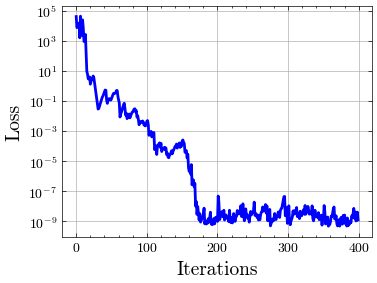

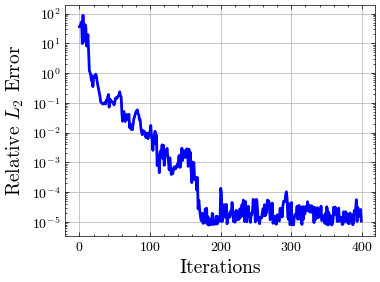

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(burgerslm_loss, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.grid()
plt.show

plt.figure(figsize=(4, 3))
plt.plot(burgerslm_l2err, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Relative $L_2$ Error', fontsize=14)
plt.grid()
plt.show

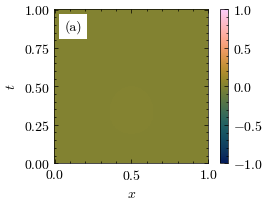

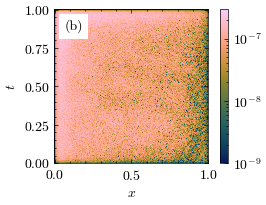

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap, rasterized=True,
                      vmin=-1,vmax=1)
fig.colorbar(ax_nn, ax=ax, pad=0.03)
ax.annotate("(a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm.pdf", format="pdf")
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-9, vmax=error.max())
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-9, norm=norm, cmap=cmap, rasterized=True,)
fig.colorbar(nn_error, ax=ax, pad=0.03)
ax.annotate("(b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm_err.pdf", format="pdf")
plt.show()